In [2]:
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gzip
import glob
import re
from DMS_utils import dna_rev_comp, translate_dna2aa
import pysam
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import json
import shutil
from evaluation_functions import *


In [2]:
base_dir = os.getcwd() 
amplicon = "RRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRV"

amplicon_DNA = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'

amplicon_DNA_corrected = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'## since all the sequenced reads have an "A" instead of "G" at the 413th position of the LOV2 gene, we correct the sequence here

# correct the sequence
# LOV_gene_corrected = list(LOV_gene)
# LOV_gene_corrected[413] = "A"
# LOV_gene_corrected = "".join(LOV_gene_corrected)

amplicon_start = "CGCCGCATGGAAGCGATTAACGAAAGCAGCGGT"
amplicon_end = "GGGAGCCTGCATCCGCCGATGGATAACCGCGTG"
LOV_gene_end_corr = "GAAAACATTGATGAAGCGGCCAAA"
LOV_gene_corrected = 'TTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAA' ## since all the sequenced reads have an "A" instead of "G" at the 413th position, we correct the sequence here

LOV_gene = "TTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAA"

LOV = "LATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAK"
gene_len = len(LOV)*3
catch_left = 'AAGCAGCGGT'
catch_right = 'GGGAGCCTGC'
offset_left = 3
offset_right= 5

genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())


quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
}


ecoli_pref = { ### codons used for retron library (RL8) construction
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}

In [306]:
Nt_codon_pref_dict = {0:{},
                     1:{},
                     2:{}}
for pos in range(3):
    for Nt in ["A", "C", "G","T"]:
        Nt_codon_pref_dict[pos][Nt] = sum([codon[pos] == Nt for codon in ecoli_pref.values()])


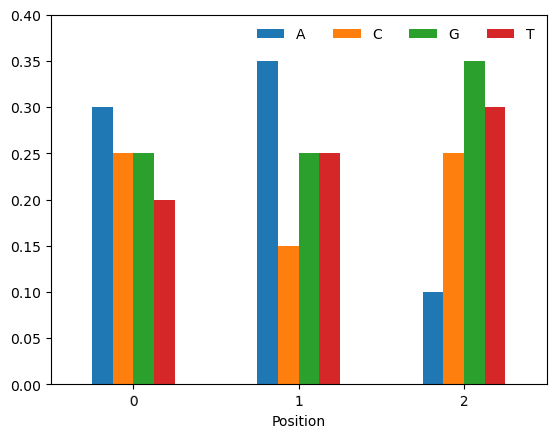

In [316]:
# grouped barplot from dict 
df = pd.DataFrame(Nt_codon_pref_dict)
df = df/df.sum(0)


df.transpose().plot.bar()
plt.legend(ncol = 4, frameon = False)
plt.ylim(0,0.4)
plt.xlabel("Position")
plt.xticks(rotation = 2)
plt.show()

# Functions

In [6]:
# def find(string, value_list):
#     indexes = [string.find(letter) for letter in value_list]
#     try: 
#         ind = min([index for index in indexes if index != -1])
#     except:
#         ind = 400 #250
#     return ind

# def read_sequences(variant, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False):
#     """
#     read sequences from fastq files while filtering for quality score (read is aborted at first nt with higher error rate than 1%)
#     arbitrary_cutoff_a: at which position to arbitrary cut off the forward reads that already went through the quality score filter (= max length of the reads)
#     arbitrary_cutoff_b: at which position to arbitrary cut off the backward reads that already went through the quality score filter (= max length of the reads)
#     returns list of sequences
#     """
#     a_sequences = []
#     b_sequences = []
#     quality_score = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*','+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5']

#     with open(f'{base_dir}/data/fastq/{variant}_R1_001.fastq', "rt") as a_file, open(f'{base_dir}/data/fastq/{variant}_R2_001.fastq', "rt") as b_file:

#         a_reader = QualityIO.FastqGeneralIterator(a_file)
#         b_reader = QualityIO.FastqGeneralIterator(b_file)
        
#         for total_read, (a, b) in enumerate(zip(a_reader, b_reader)):
#                 a_id, a_seq, a_qual = a
#                 b_id, b_seq, b_qual = b
#                 cutoff_a = find(a_qual, quality_score)
#                 cutoff_b = find(b_qual, quality_score)

#                 if arbitrary_cutoff_a and catch_left in a_seq: # cut off a_seq to an (arbitrary) chosen maximum length (=arbitrary_cutoff_a)
#                     if cutoff_a > (a_seq.index(catch_left) + arbitrary_cutoff_a):
#                         cutoff_a = a_seq.index(catch_left)  + len(catch_left) + arbitrary_cutoff_a 
                
#                 if arbitrary_cutoff_b and dna_rev_comp(catch_right) in b_seq: 
#                     if cutoff_b > (b_seq.index(dna_rev_comp(catch_right)) + arbitrary_cutoff_b):
#                         cutoff_b =b_seq.index(dna_rev_comp(catch_right))+ len(catch_right) + arbitrary_cutoff_b

#                 a_sequences.append(a_seq[:cutoff_a])
#                 b_sequences.append(b_seq[:cutoff_b])
#         print("total reads", total_read+1)

#     return a_sequences, b_sequences


# def read_filtering(a_seqs, b_seqs, catch_left = catch_left, catch_right = catch_right, n_mut_treshold = 10, ref_gene = LOV_gene): 
#     """
#     filter out reads with more than n_mut_treshold mutations to get rid of reads with indels that lead to frameshifts and scew the results (as we are here only interested in mutations)
#     """

#     a_sequences = []
#     b_sequences = []

#     for a_seq, b_seq in zip(a_seqs, b_seqs):
#             if catch_left in a_seq:
#                 index = a_seq.index(catch_left) + len(catch_left)
#                 gene_a = a_seq[index:]
#                 total_muts_a = sum([ref_gene[idx] != gene_a[idx] for idx in range(len(gene_a))])
#                 if total_muts_a <= n_mut_treshold: 
#                     a_sequences.append(a_seq)
#                 else: 
#                     a_sequences.append("")
#             else: 
#                 a_sequences.append("")
                     
#             if dna_rev_comp(catch_right) in b_seq:
#                 index = b_seq.index(dna_rev_comp(catch_right)) + len(catch_right)
#                 gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
#                 total_muts_b = sum([ref_gene[::-1][idx] != gene_b[::-1][idx] for idx in range(len(gene_b))])

#                 if total_muts_b <= n_mut_treshold:
#                     b_sequences.append(b_seq)
#                 else:
#                     b_sequences.append("")
#             else: 
#                 b_sequences.append("")

#     print("total forward reads after filtering", sum([a_seq != "" for a_seq in a_sequences]))
#     print("total reverse reads after filtering", sum([b_seq != "" for b_seq in b_sequences]))
#     return a_sequences, b_sequences


# def gather_AA_variants(a_seq, b_seq,use_backward_read=True, use_forward_read = True, catch_left = catch_left, catch_right = catch_right, ref_prot = LOV):
#     """
#     returns a dictionary with the counts of each amino acid at each position
#     n_mut_treshold: maximum number of mutations allowed (to filter out reads with indels leading to frameshifts that scew the results, as we are only interested in mutations)

#     """
#     mutation_dict = {}
#     catch_length = len(catch_left)
    
#     for idx in range(len(ref_prot)):
#         mutation_dict[idx] = {'A':0, 'C':0, 'D':0, 'E':0, 'F':0, 'G':0, 
#                             'H':0, 'I':0, 'K':0, 'L':0, 'M':0, 'N':0, 
#                             'P':0, 'Q':0, 'R':0, 'S':0, 'T':0, 'V':0, 
#                             'W':0, 'Y':0, '*':0, 'wt':0}
#     for a_seq, b_seq in zip(a_seq, b_seq):
#         if use_forward_read:
#             if catch_left in a_seq:
#                 index = a_seq.index(catch_left) + catch_length
#                 gene_a = a_seq[index:]
#                 tr_a = translate_dna2aa(gene_a)

#                 for idx, pos in enumerate(tr_a):
#                     mutation_dict[idx][pos] += 1

#         if use_backward_read: 
#             if dna_rev_comp(catch_right) in b_seq:
#                 index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
#                 gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
#                 tr_b = translate_dna2aa(gene_b)
#                 tr_b = tr_b[::-1]
            
#                 for idx, pos in enumerate(tr_b):
#                     mutation_dict[len(ref_prot)-idx-1][pos] += 1
#     return mutation_dict

# def gather_codon_variants(a_seq, b_seq , use_backward_read= True,use_forward_read = True, catch_left = catch_left, catch_right = catch_right, codons = codons):
#     """
#     returns a dictionary with the counts of each codon at each position
#     """
#     mutation_dict = {}
#     catch_length = len(catch_left)
#     gene_len = len(LOV)*3
    
#     for idx in range(0, gene_len//3):
#         mutation_dict[idx] = {codon: 0 for codon in codons}

#     for a_seq, b_seq in zip(a_seq, b_seq):
#         if use_forward_read: 
#             if catch_left in a_seq:
#                 index = a_seq.index(catch_left) + catch_length
#                 gene_a = a_seq[index:]

#                 for i in range(0,len(gene_a)//3*3,3): # triplets
#                     mutation_dict[i//3][gene_a[i:i+3]] += 1

#         if use_backward_read:
#             if dna_rev_comp(catch_right) in b_seq:
#                 index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
#                 gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
             
#                 codons = [gene_b[i:i+3] for i in range(0,len(gene_b),3)]
#                 if len(gene_b) >= 3:
#                     for idx in range(len(codons)): # triplets 
#                         codon = codons[-idx-1]
#                         if codon:
#                             mutation_dict[len(mutation_dict)-idx-1][codon] += 1 # start from the end and update the mutation_dict for each triplet

#     return mutation_dict



# def gather_nt_variants(a_seq, b_seq , use_backward_read= True,use_forward_read = True, catch_left = catch_left, catch_right = catch_right):
#     """
#     returns a dictionary with the counts of each nt at each position
#     """
#     mutation_dict = {}
#     catch_length = len(catch_left)
#     gene_len = len(LOV)*3
    
#     for idx in range(gene_len):
#         mutation_dict[idx] = {'A':0, 'T':0, 'G':0, 'C':0}

#     for a_seq, b_seq in zip(a_seq, b_seq):
#         if use_forward_read: 
#             if catch_left in a_seq:
#                 index = a_seq.index(catch_left) + catch_length
#                 gene_a = a_seq[index:]

#                 for idx, pos in enumerate(gene_a):
#                     mutation_dict[idx][pos] += 1

#         if use_backward_read:
#             if dna_rev_comp(catch_right) in b_seq:
#                 index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
#                 gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])

#                 gene_b = gene_b[::-1]
#                 for idx, pos in enumerate(gene_b):
#                     mutation_dict[gene_len-idx-1][pos] += 1

#     return mutation_dict


# def process_reads(AA_sequence,use_backward_read = True, use_forward_read = True, arbitrary_cutoff_a = False, arbitrary_cutoff_b= False, variants = None, filter_for_n_mut = True, n_mut_treshold=10):
#     """
#     process reads for given variants
#     use_backward_read: whether or not to use the backward read
#     arbitrary_cutoff: where to cut off the forward sequence (maximum length of the reads, otherwise the cutoff is determined by the quality score = 1% error rate)
#     if variants = None, all variants stored in the fastq folder are processed
#     """
#     variants_dict = {}
#     path = f'{base_dir}/data/fastq'
#     filenames = glob.glob(f'{path}/*')

#     if variants is not None: # filter filenames for given variants
#         filenames = [path for path in filenames if any(variant in path for variant in variants)]

#     for name in filenames: 
#         if '_R1' in name:
#             name = name.split('/')[-1].split('_R')[0]
#             f1 = name
#             a_seq, b_seq = read_sequences(f1, arbitrary_cutoff_a = arbitrary_cutoff_a, arbitrary_cutoff_b=arbitrary_cutoff_b)
#             if filter_for_n_mut:
#                 a_seq, b_seq = read_filtering(a_seq, b_seq, n_mut_treshold = n_mut_treshold)
#             variants_dict[name] = {}
#             variants_dict[name] = get_variants(a_seq,b_seq,use_backward_read=use_backward_read,use_forward_read=use_forward_read)

#             print(f'Done: {name}')

#         # with open(f'{path}/{variant}_variants.pickle', 'wb') as handle:
#         #     pkl.dump(variants_dict, handle)
#     return variants_dict

# def get_variants(a_seq,b_seq,use_backward_read=True,use_forward_read=True):
    
#     variants_dict = {}
#     variants_dict["AA"] = gather_AA_variants(a_seq, b_seq, use_backward_read=use_backward_read, use_forward_read=use_forward_read)
#     variants_dict["DNA"] = gather_nt_variants(a_seq, b_seq, use_backward_read=use_backward_read, use_forward_read=use_forward_read)
#     variants_dict["Codons"] = gather_codon_variants(a_seq, b_seq, use_backward_read=use_backward_read, use_forward_read=use_forward_read)

#     return variants_dict


In [42]:
## evaluation 

### calculate sum of single, double and triple mutants
def gather_n_mutations(a_seq, b_seq, reference_seq, use_backward_read = True, use_forward_read = True, use_triplets = False, treshold = 10):
    """
    returns a dictionary with the number of single, double, triple (...) mutants
    a_seq, b_seq = list of sequences
    """
    mutation_dict = {}
    catch_length = len(catch_left)
    gene_len = len(LOV)*3
    
    
    for a_seq, b_seq in zip(a_seq, b_seq):
        
        if use_forward_read and catch_left in a_seq:
            index = a_seq.index(catch_left) + catch_length
            gene_a = a_seq[index:]
            if use_triplets: 
                n_muts_a_seq = sum([reference_seq[i:i+3] != gene_a[i:i+3] for i in range(0,len(gene_a)//3*3,3)])
            else: 
                n_muts_a_seq = sum([reference_seq[i] != gene_a[i] for i in range(len(gene_a))])

        else: n_muts_a_seq = 0
            
        if use_backward_read and dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                gene_b = gene_b[::-1]
                n_muts_b_seq = sum([reference_seq[::-1][i] != gene_b[i] for i in range(len(gene_b))])
                
        else: n_muts_b_seq = 0

        n_muts = n_muts_a_seq + n_muts_b_seq

        if n_muts in mutation_dict:
            mutation_dict[n_muts] += 1
        else:
            mutation_dict[n_muts] = 1

    return mutation_dict


### calculate the mutagenic spectrum
def mut_spectrum(a_seq, b_seq, reference_seq, use_backward_read = True, use_forward_read = True, catch_left = catch_left, catch_right = catch_right, treshold = 10):
    """
    input: 
    a_seq, b_seq = list of sequences
    reference_seq = reference sequence
    
    returns two dictionaries: (1) with the total counts of the mutagenic spectrum and (2) dict with percentage of the mutagenic spectrum
    with the following structure: {reference nt: {mutated nt: count/percentage}}
    """
    ## reference nt : {mutated nt: count}
    mut_spec = {'A': {'A':0, 'C':0, 'G':0, 'T':0},
                'C': {'A':0, 'C':0, 'G':0, 'T':0},
                'G': {'A':0, 'C':0, 'G':0, 'T':0},
                'T': {'A':0, 'C':0, 'G':0, 'T':0}}
    
    for a_seq, b_seq in zip(a_seq, b_seq):
                
        if use_forward_read: 
            if catch_left in a_seq:
                index = a_seq.index(catch_left) + len(catch_left)
                gene_a = a_seq[index:]
            
                for idx, nt in enumerate(gene_a): 
                    if reference_seq[idx] != nt:
                        mut_spec[reference_seq[idx]][nt] += 1
                
        if use_backward_read:        
            if dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + len(catch_right)
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                gene_b = gene_b[::-1]

                for idx, nt in enumerate(gene_b):
                    if reference_seq[::-1][idx] != nt:
                        mut_spec[reference_seq[::-1][idx]][nt] += 1
    
    ## calculate mutagenic spectrum in percentage
    total_n_muts = sum([sum(value.values()) for value in mut_spec.values()])
    mut_spec_perc = {ref_base: {mut_base: round(val/total_n_muts*100, 3) for mut_base, val in value.items()} for ref_base, value in mut_spec.items()}

    return mut_spec, mut_spec_perc

### calculate the mutagenic spectrum codon-wise
def mut_spectrum_codons(a_seq, b_seq, reference_seq, use_backward_read = False, use_forward_read = True, codon_list = codons, catch_left = catch_left, catch_right = catch_right, treshold = 10):
    """
    input: 
    a_seq, b_seq = list of sequences
    reference_seq = reference sequence
    
    returns two dictionaries: (1) with the total counts of the mutagenic spectrum of codons and (2) dict with percentage of the mutagenic spectrum
    with the following structure: {reference codon: {mutated codon: count/percentage}}
    """
    ## reference codon : {mutated codon: count}
    mut_spec = {ref_codon: {codon:0 for codon in codon_list} for ref_codon in codon_list}

    for a_seq, b_seq in zip(a_seq, b_seq):
                
        if use_forward_read: 
            if catch_left in a_seq:
                index = a_seq.index(catch_left) + len(catch_left)
                gene_a = a_seq[index:]
                
                for idx in range(0,len(gene_a)//3*3,3): 
                    if reference_seq[idx:idx+3] != gene_a[idx:idx+3]:
                        mut_spec[reference_seq[idx:idx+3]][gene_a[idx:idx+3]] += 1
                
        if use_backward_read:        
            if dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + len(catch_right)
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                gene_b = gene_b[::-1]
                
                for idx in range(0,len(gene_b)//3*3,3):
                    if reference_seq[::-1][idx:idx+3] != gene_b[idx:idx+3]:
                        mut_spec[reference_seq[::-1][idx:idx+3]][gene_b[idx:idx+3]] += 1
    
    ## calculate mutagenic spectrum in percentage
    total_n_muts = sum([sum(value.values()) for value in mut_spec.values()])
    mut_spec_perc = {ref_base: {mut_base: round(val/total_n_muts*100, 3) for mut_base, val in value.items()} for ref_base, value in mut_spec.items()}

    return mut_spec, mut_spec_perc


def plot_mutation_spectrum(data, samplename , fig_folder = None, colormap = "viridis"):
    """
    plot mutation spectrum (%) as heatmap
    data = dataframe with the mutagenic spectrum (rows = reference nt, columns = mutated nt)
    savepath = folder path to save the figure
    """
    f, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(data, annot=True, linewidths=.5, ax=ax, vmin = 0, cbar = False, square = True, linecolor = "black", cmap = colormap)
    plt.xlabel('Mutated base (%)', fontsize = 10)
    plt.ylabel('Reference base (%)', fontsize = 10)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(.5)
    #ax.set_facecolor('gray')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=1, fontsize=10)
    plt.title(f"{samplename} mutagenic spectrum", fontsize = 12)
    if fig_folder is not None:
        plt.savefig(f"{fig_folder}/{samplename}_mutagenic_spectrum_perc.pdf")
    plt.show()


# def plot_mutation_enrichment(data, name, ref_seq, backward = False, data_type = "DNA", fig_folder = None):
#     """
#     data_type = "DNA", "AA" or "Codons" 
#     reference nucleotides/AAs/Codons are shown in grey (set to NA)
#     backward: if True, only backward reads are used
#     input data should be a dataframe with the relative counts of each nucleotide/AA/Codon at each position
#     name = plot title
#     """
#     #process data
#     if data_type == "DNA":
#         Nt_order = ['A','C', 'G', 'T']
#         data = data.loc[Nt_order]
#     elif data_type == "AA": 
#         AA_order = ['A','I','L','M','F','W','Y','V','S','T','N','Q','R','H','K','D','E','C','G','P','*']
#         data = data.loc[AA_order]
    
#     read_len = data.shape[1]
    
#     if data_type in ["DNA", "AA"]:
#         if backward: 
#             for idx in range(read_len):
#                 data.loc[ref_seq[::-1][idx], len(ref_seq)-idx-1] = np.nan
#             seq_pos = [x for x in ref_seq[-read_len:]] ## for xlabel in plot
            
#         else: 
#             for idx in range(read_len):
#                 data.loc[ref_seq[idx], idx] = np.nan
        
#             seq_pos = [x for x in ref_seq[:read_len]] ## for xlabel in plot

#     elif data_type == "Codons":
#         codons = [ref_seq[idx:idx+3] for idx in range(0,len(ref_seq),3)]
#         if backward: 
#             for idx in range(read_len):
#                 data.loc[codons[::-1][idx], len(codons)-idx-1] = np.nan
#             seq_pos = [x for x in codons[-read_len:]] ## for xlabel in plot
        
#         else: 
#             for idx in range(read_len):
#                 data.loc[codons[idx], idx] = np.nan
#             seq_pos = [x for x in codons[:read_len]]## for xlabel in plot

#     plt.figure(figsize=(30,10))
#     sns.reset_defaults()
    
#     #sns.set(font_scale =5)
#     ax = sns.heatmap(data=data, cmap='viridis', cbar_kws={'label': f"relative counts", "pad": 0.02}, yticklabels=True, xticklabels = True)
#     plt.title(name, fontsize=20)
#     for _, spine in ax.spines.items():
#         spine.set_visible(True)
#         spine.set_linewidth(2)
#     ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=10)
#     ax.xaxis.set_tick_params(width=2)
#     rotation = 90 if data_type == "Codons" else 1
#     ax.set_xticklabels(seq_pos, rotation=rotation, fontsize=10)
#     ax.yaxis.set_tick_params(width=2)
#     ax.set_facecolor('gray')
#     ax.grid(False)
#     if fig_folder is not None:    
#         plt.savefig(f"{fig_folder}/{name}_mutation_enrichement.pdf", bbox_inches="tight")
#     plt.xlabel("LOV2 sequence", fontsize = 20)
#     plt.show()
#     plt.close()

def coverage_plot(data, variant_name = "", xticks = list(range(0,430, 50)), FigFolder = None): 
    """
    data is a df with the coverage of each position, e.g by calling seq_variants["DNA"].sum()
    """

    ## plot coverage 

    ax = sns.barplot(data)
    plt.xticks(xticks)
    plt.xlabel("Position")
    plt.ylabel("Read counts")
    plt.title(f'{variant_name} DNA coverage')
    if FigFolder:
        plt.savefig(f'{FigFolder}/{variant_name}_DNA_coverage.pdf')
    plt.show()

def plot_mut_rate_per_pos(data, variant_name, FigFolder, ref_seq = LOV_gene):
    """
    data is a df with the mutation rate of each position, e.g by calling DNA_relative.sum()-DNA_relative.max() or seq_variants["DNA"].sum()-seq_variants["DNA"].max()/seq_variants["DNA"].sum()
    """
    plt.figure(figsize=(20,2))
    x_ticklabels = [Nt for Nt in ref_seq[:len(data)]]
    sns.heatmap(pd.DataFrame(data).T, cmap = "viridis", cbar = True, cbar_kws = {"pad": 0.02, "label": "Mutation rate" },linecolor="black", xticklabels=x_ticklabels, yticklabels=False)
    #ax.set_xticks(ticks = list(range(len(mut_rate_per_pos))),  labels = [Nt for Nt in LOV_gene[:len(mut_rate_per_pos)]])
    plt.xlabel("Position")
    plt.xticks(rotation = 2,fontsize=6)
    plt.title(variant_name)
    #plt.savefig(f"{FigFolder}/{name}_mutation_rate_per_Nt_position.pdf", bbox_inches="tight")
    plt.show()
    plt.clf()

# AraC analysis

### NOTE that the quality score cutoff is set to a 1 % error rate

In [7]:
### set parameters
variant = "DP6"
name = "DP6"
n_mut_treshold = 10
FigFolder = None #f"{base_dir}/figures/{name}"
use_backward_read = False
use_forward_read = True
arbitrary_cutoff_a = False
arbitrary_cutoff_b = False


# if not os.path.exists(FigFolder):
#     os.makedirs(FigFolder)

## read sequences
seq_variants = process_reads(AA_sequence=amplicon, variants = [variant], use_backward_read=use_backward_read, use_forward_read=use_forward_read, arbitrary_cutoff_a=arbitrary_cutoff_a, arbitrary_cutoff_b=arbitrary_cutoff_b, n_mut_treshold = n_mut_treshold, filter_for_n_mut=True)

seq_variants["DNA"] = pd.DataFrame.from_dict(seq_variants[variant]["DNA"])
seq_variants["DNA"] = seq_variants["DNA"].loc[:,seq_variants["DNA"].sum() > 0]
seq_variants["AA"] = pd.DataFrame.from_dict(seq_variants[variant]["AA"])
seq_variants["AA"] = seq_variants["AA"].loc[:,seq_variants["AA"].sum() > 0]
seq_variants["Codons"] = pd.DataFrame.from_dict(seq_variants[variant]["Codons"])
seq_variants["Codons"] = seq_variants["Codons"].loc[:,seq_variants["Codons"].sum() > 0]

total reads 59259
total forward reads after filtering 41519
total reverse reads after filtering 35236
Done: DP6


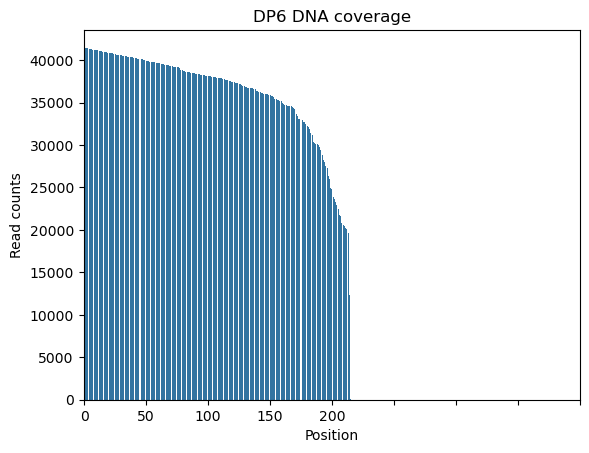

In [27]:
## plot coverage 
coverage_plot(seq_variants["DNA"].sum(), variant_name=variant, FigFolder=FigFolder)


In [28]:
coverage = seq_variants['DNA'].sum().sum()/(seq_variants['DNA'].max().max()*seq_variants['DNA'].shape[1])*100
print(f'The illumina paired reads cover on average {coverage.round(1)} % of the LOV sequence')

mut_rate_AA = seq_variants['AA'].max()/seq_variants['AA'].sum()-1
mut_rate_AA = abs(mut_rate_AA.sum())
print(f'The mutation rate is estimated to be {mut_rate_AA.round(3)} AA mutations per sequence')
print(f'If we correct for the coverage, we expect a mutation rate of {round(mut_rate_AA/coverage*100,3)} AA mutations per sequence')

mut_rate_DNA = seq_variants['DNA'].max()/seq_variants['DNA'].sum()-1
mut_rate_DNA = abs(mut_rate_DNA.sum())  # this is the mutation rate per nucleotide, based on the number of reads (per nt)
print(f'The mutation rate is estimated to be {mut_rate_DNA.round(3)} DNA mutations per sequence') 
print(f'If we correct for the coverage, we expect a mutation rate of {round(mut_rate_DNA/coverage*100,3)} DNA mutations per sequence')

mut_rate_Codons = seq_variants['Codons'].max()/seq_variants['Codons'].sum()-1
mut_rate_Codons = abs(mut_rate_Codons.sum())
print(f'The mutation rate is estimated to be {mut_rate_Codons.round(3)} Codon mutations per sequence')
print(f'If we correct for the coverage, we expect a mutation rate of {round(mut_rate_Codons/coverage*100,3)} Codon mutations per sequence')

mut_rates_dict = {"variant": name, 
                  "coverage": coverage,
                  "AA_mut_per_sequence": mut_rate_AA,
                  #"AA_mut_per_sequence_coverage_corrected": mut_rate_AA/coverage*100,
                  "DNA_mut_per_sequence": mut_rate_DNA,
                  #"DNA_mut_per_sequence_coverage_corrected": mut_rate_DNA/coverage*100, 
                  "Codon_mut_per_sequence": mut_rate_Codons,
                  #"Codon_mut_per_sequence_coverage_corrected": mut_rate_Codons/coverage*100
                  }
if FigFolder: 
    with open(f'{FigFolder}/{name}_mutation_rates.json', 'w') as file:
        file.write(json.dumps(mut_rates_dict, indent=4))

The illumina paired reads cover on average 86.5 % of the LOV sequence
The mutation rate is estimated to be 0.098 AA mutations per sequence
If we correct for the coverage, we expect a mutation rate of 0.113 AA mutations per sequence
The mutation rate is estimated to be 0.148 DNA mutations per sequence
If we correct for the coverage, we expect a mutation rate of 0.171 DNA mutations per sequence
The mutation rate is estimated to be 0.143 Codon mutations per sequence
If we correct for the coverage, we expect a mutation rate of 0.165 Codon mutations per sequence


<Figure size 640x480 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

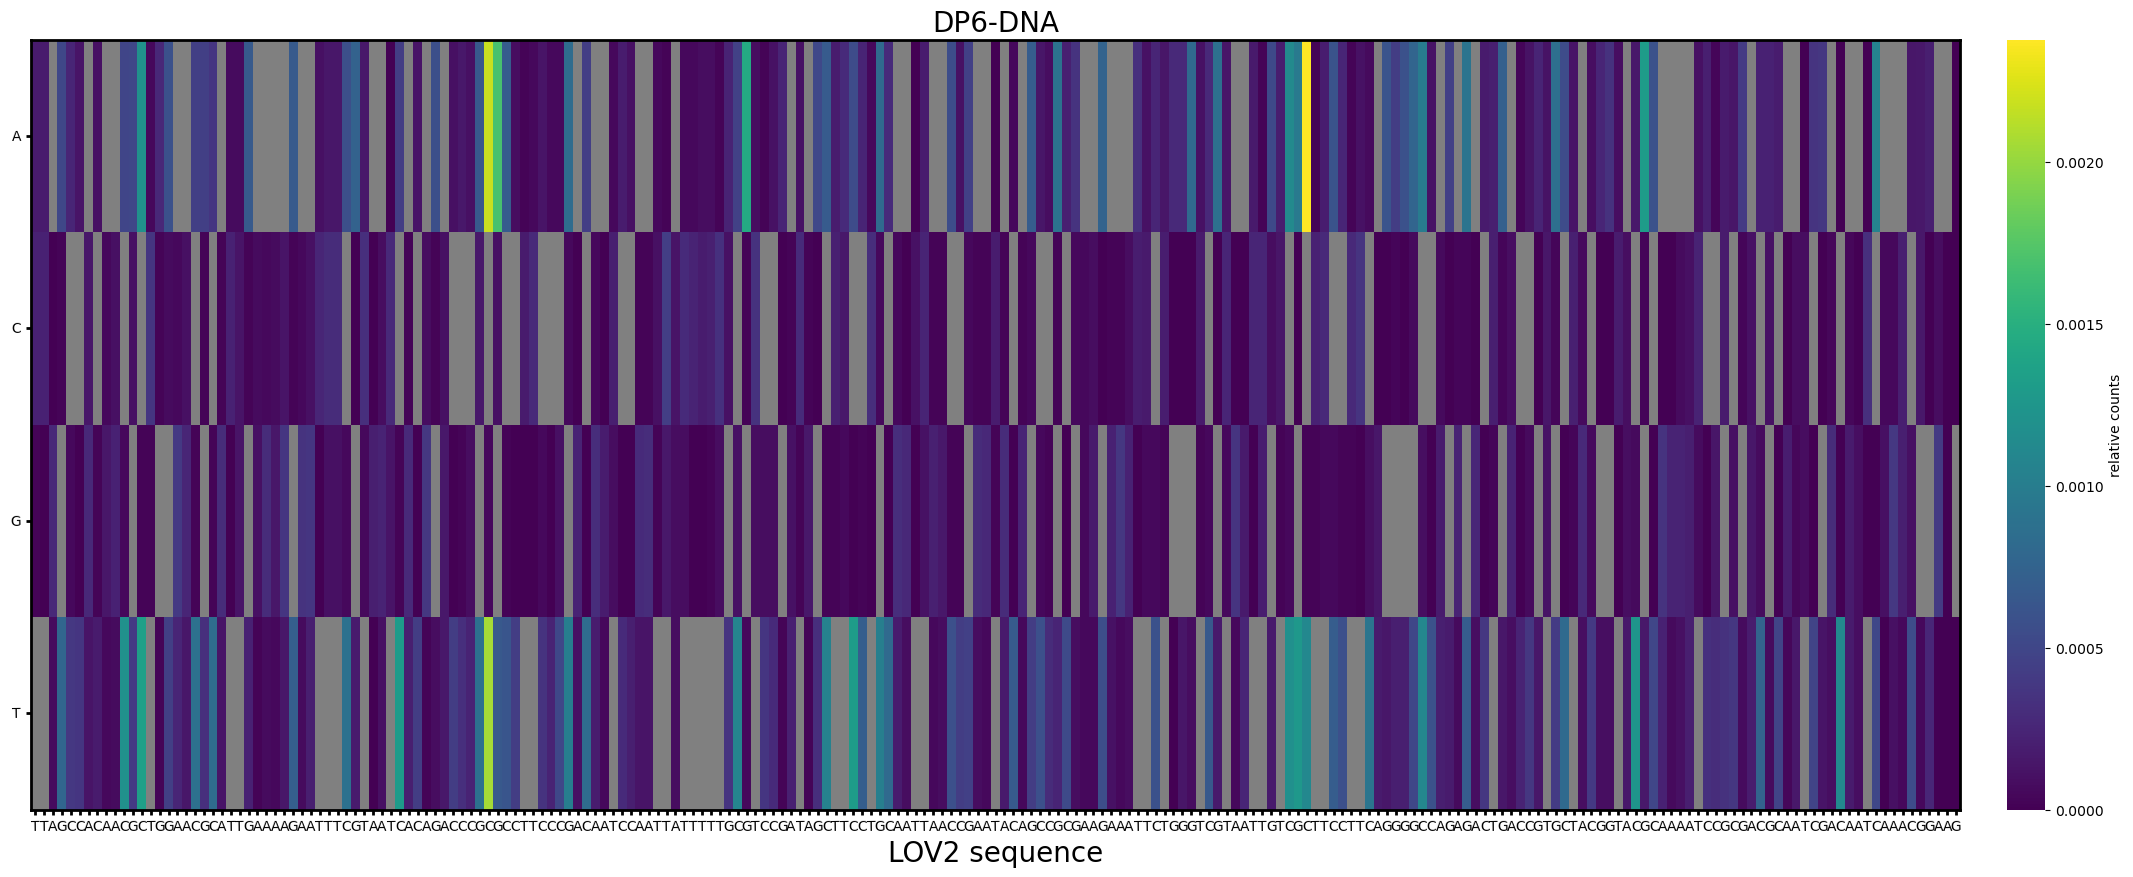

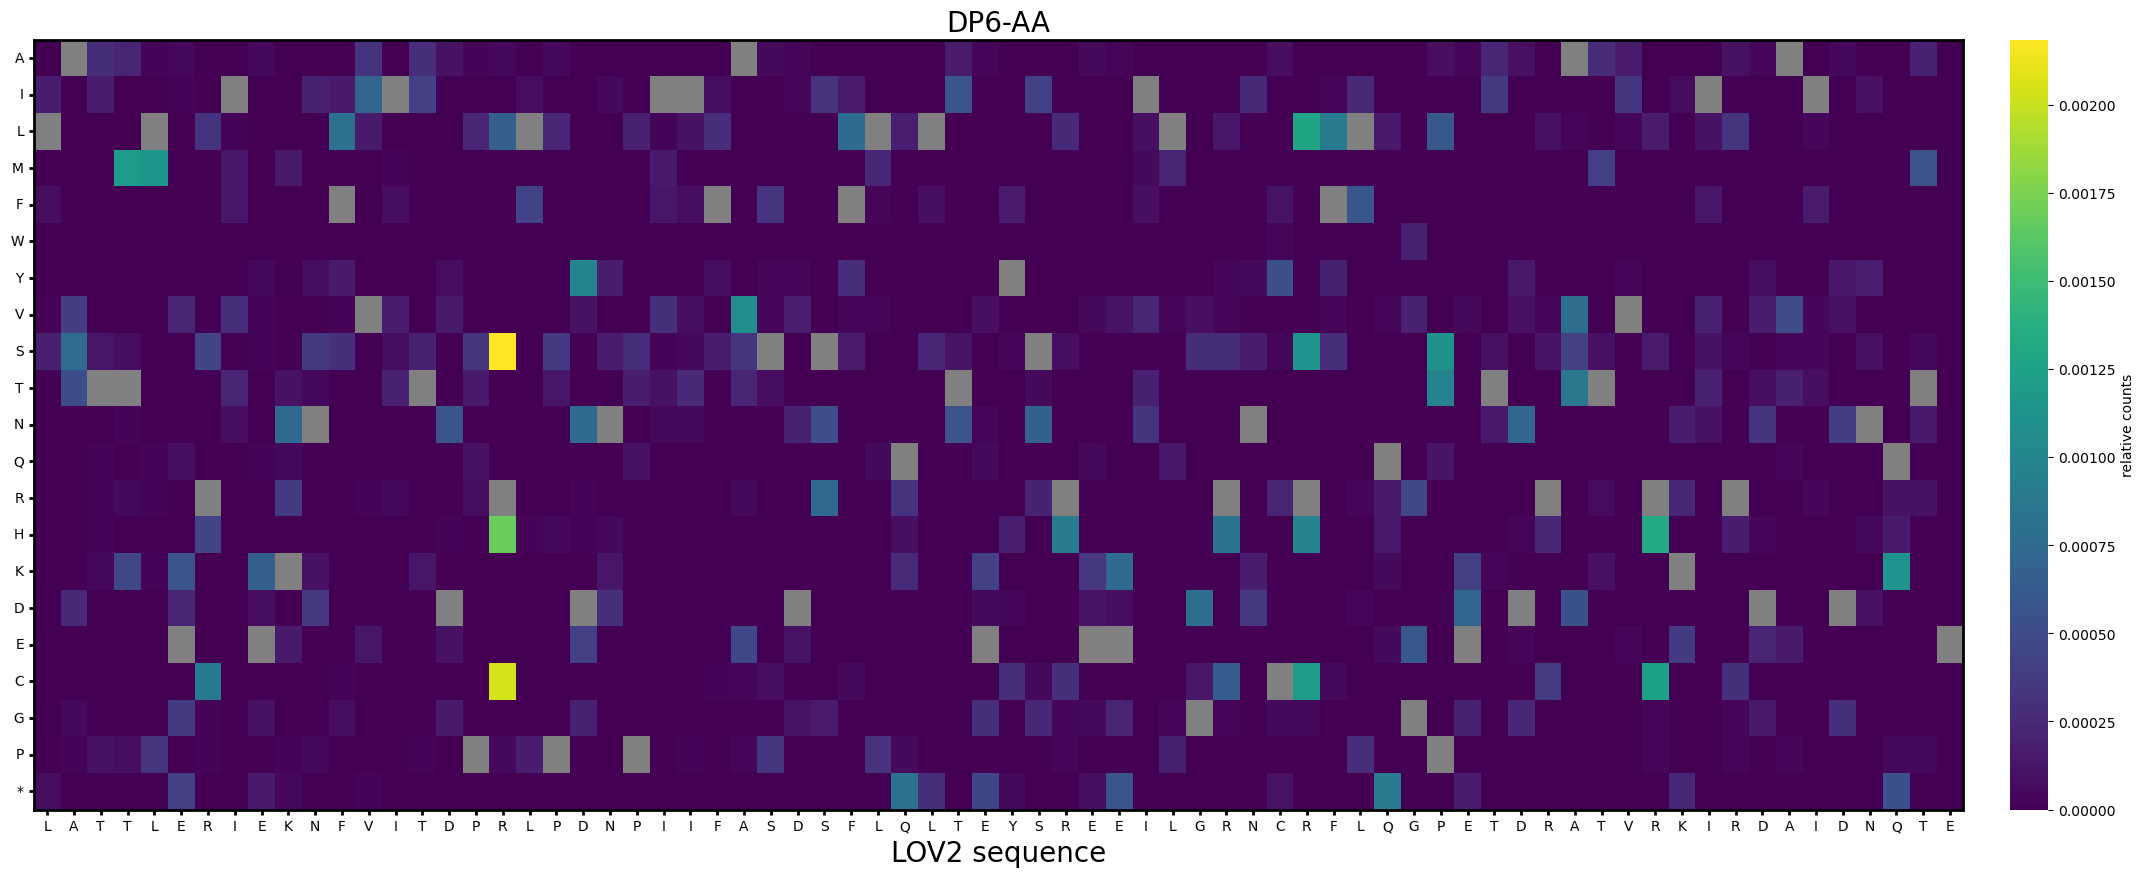

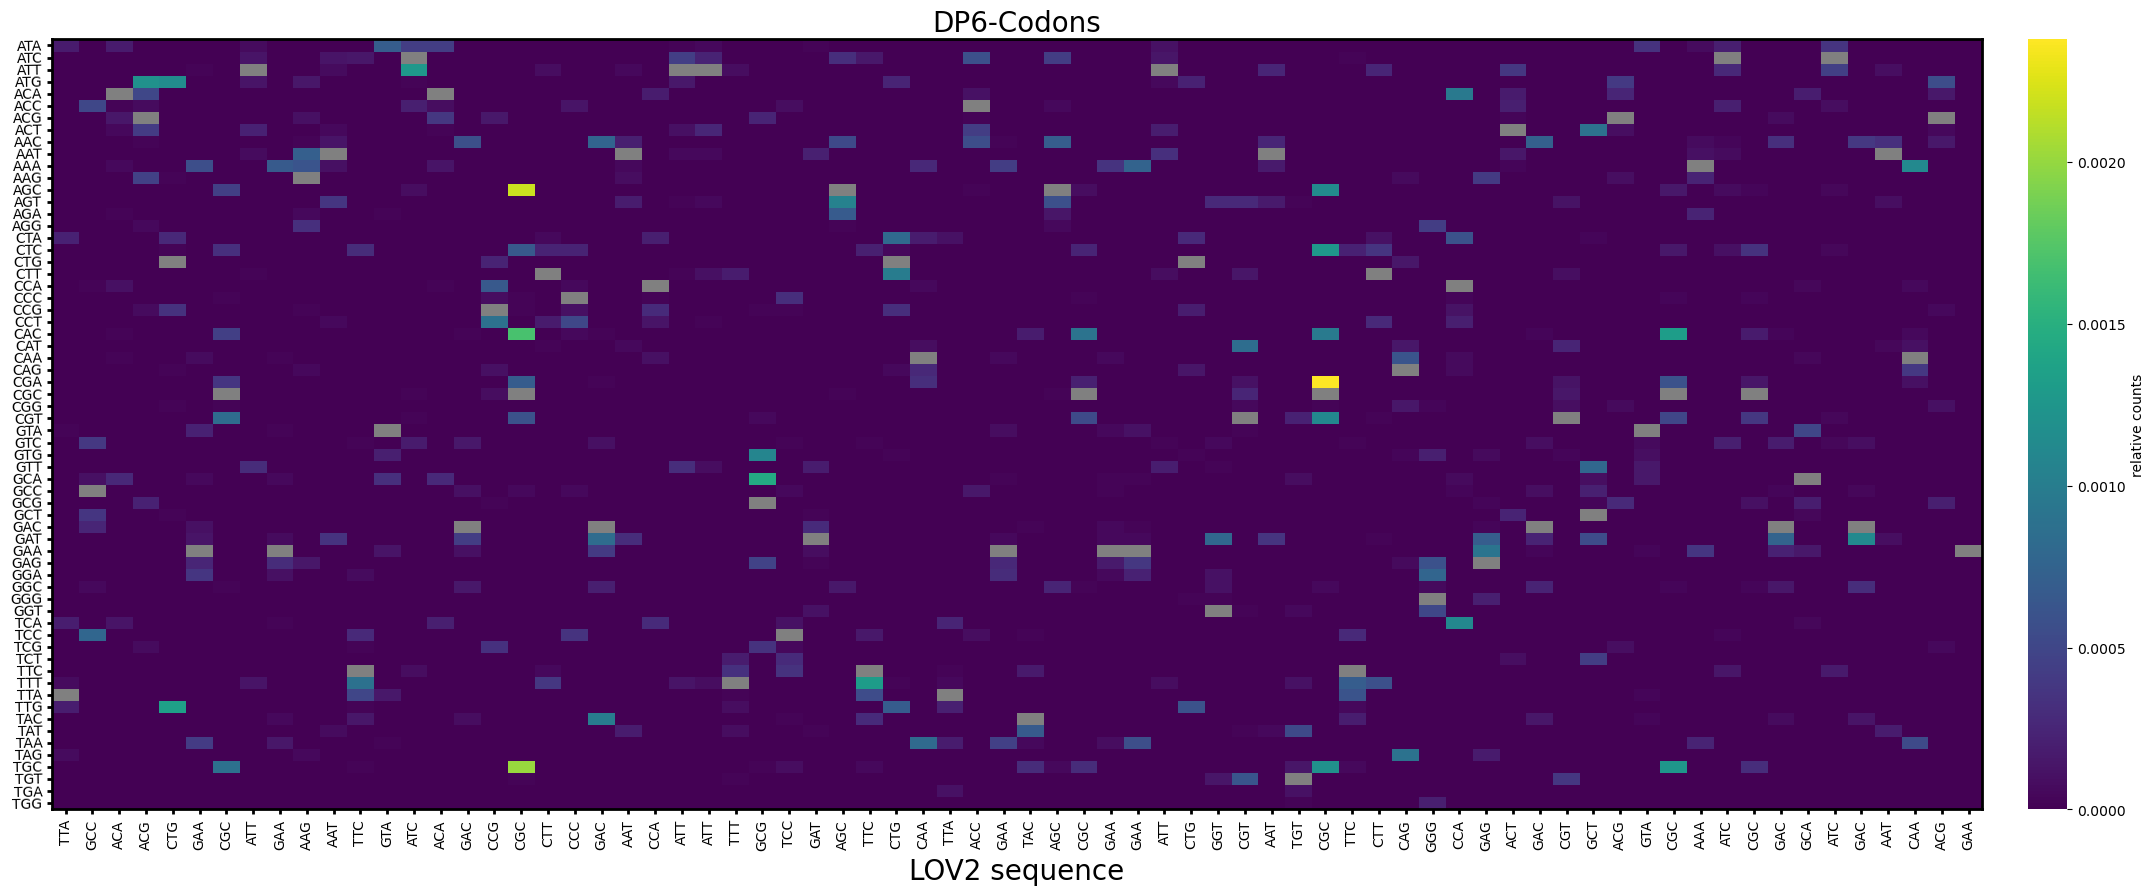

In [43]:
## plot mutation enrichment on DNA, AA and Codon level 

DNA_relative = seq_variants['DNA']/seq_variants['DNA'].sum()
DNA_relative.dropna(axis = 1, inplace=True)
plot_mutation_enrichment(DNA_relative, name =  f'{name}-DNA', backward= not use_forward_read, data_type = "DNA", ref_seq=LOV_gene_corrected, fig_folder=FigFolder)

AA_relative = seq_variants['AA']/seq_variants['AA'].sum()
AA_relative.dropna(axis = 1, inplace=True)
plot_mutation_enrichment(AA_relative, f'{name}-AA',ref_seq=LOV,data_type = "AA", backward = not use_forward_read, fig_folder=FigFolder)

Codons_relative = seq_variants['Codons']/seq_variants['Codons'].sum()
Codons_relative.dropna(axis = 1, inplace=True)
plot_mutation_enrichment(Codons_relative, f'{name}-Codons',ref_seq=LOV_gene_corrected,data_type = "Codons", backward = not use_forward_read, fig_folder=FigFolder)


In [39]:
x 
#plot_mut_rate_per_pos()
x

0      0.000410
1      0.000386
2      0.000338
3      0.001305
4      0.000678
         ...   
212    0.000349
213    0.000457
214    0.000488
215    0.000000
216    0.000000
Length: 217, dtype: float64

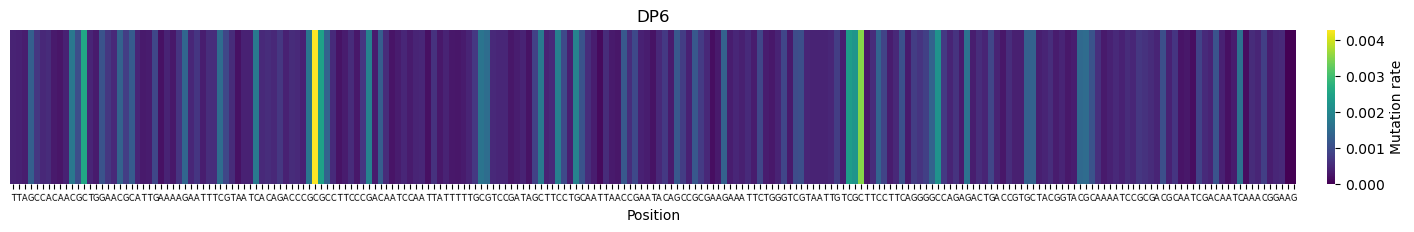

<Figure size 640x480 with 0 Axes>

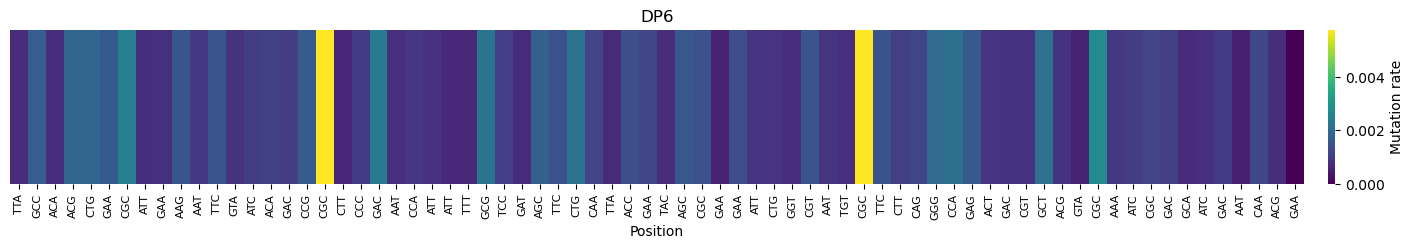

In [44]:
## plot mutation rate per position 
DNA_mut_rate_per_pos = (seq_variants["DNA"].sum()-seq_variants["DNA"].max())/seq_variants["DNA"].sum()

plot_mut_rate_per_pos(DNA_mut_rate_per_pos, variant_name = variant, FigFolder = FigFolder)

Codon_mut_rate_per_pos = Codons_relative.sum()-Codons_relative.max()
LOV_codons = [LOV_gene[i:i+3] for i in range(0, len(Codon_mut_rate_per_pos)*3, 3)]

plt.figure(figsize=(20,2))
sns.heatmap(pd.DataFrame(Codon_mut_rate_per_pos).T, cmap = "viridis", cbar = True, cbar_kws = {"pad": 0.015, "label": "Mutation rate" },linecolor="black", xticklabels=LOV_codons, yticklabels=False)
plt.xlabel("Position")
plt.xticks(fontsize=8)
plt.title(name)
#plt.savefig(f"{FigFolder}/{name}_mutation_rate_per_Codon_position.pdf", bbox_inches = "tight")
plt.show()
plt.clf()

In [756]:
## calculate and plot the number of Nt and Codon mutations per sequence

a_seq, b_seq = read_sequences(variant)
seq_n_Nt_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=use_backward_read, use_triplets=False, treshold = treshold)
seq_n_Nt_mutations = dict(sorted(seq_n_Nt_mutations.items())) ## sort dictionary after key

seq_n_Codon_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=use_backward_read, use_triplets=True, treshold = treshold)
seq_n_Codon_mutations = dict(sorted(seq_n_Codon_mutations.items())) ## sort dictionary after key

print("Nt mutations", seq_n_Nt_mutations)
print("Codon mutations", seq_n_Codon_mutations)

total reads 47233
Nt mutations {0: 38172, 1: 1642, 2: 2339, 3: 2670, 4: 298, 5: 239, 6: 134, 7: 29, 8: 15, 9: 7, 10: 7}
Codon mutations {0: 37066, 1: 6329, 2: 880, 3: 92, 4: 21, 5: 1, 6: 2}


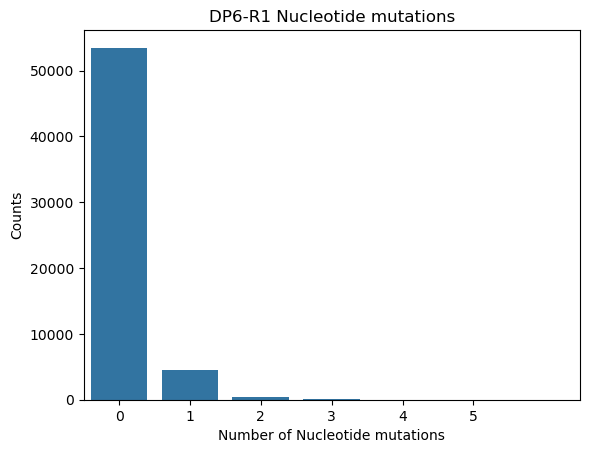

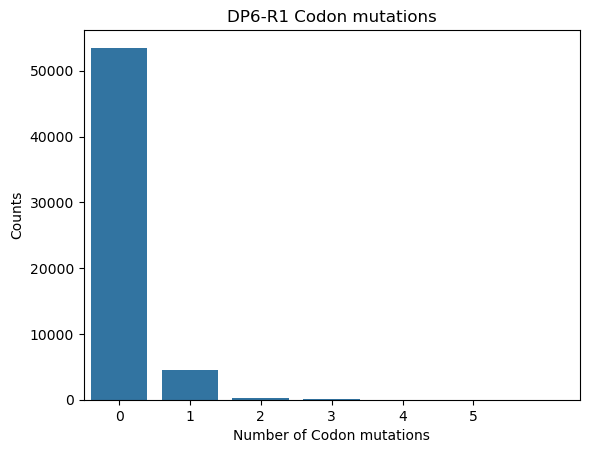

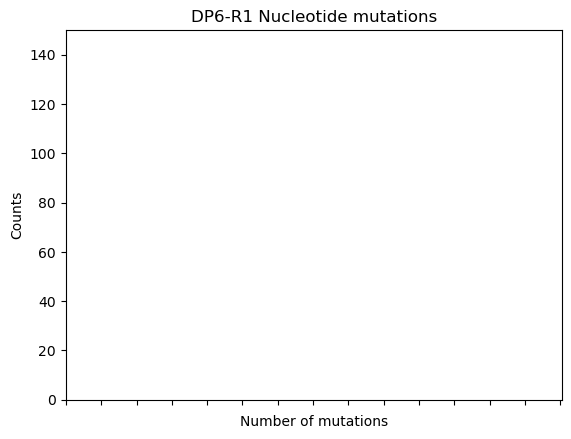

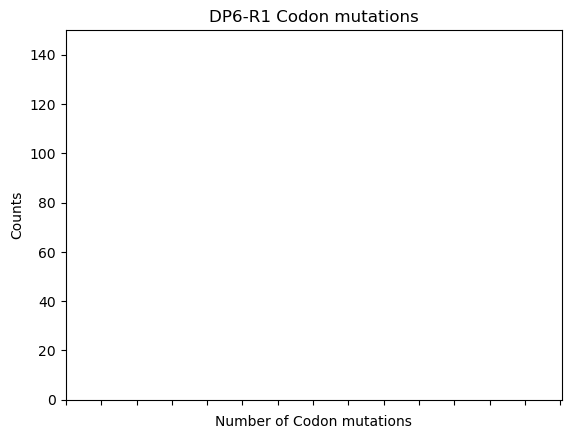

In [481]:
## plot number of Nt mutations

sns.barplot(seq_n_Nt_mutations)
plt.xlim(-0.5,6.5)
plt.xlabel('Number of Nucleotide mutations')
plt.ylabel('Counts')
plt.title(f'{name} Nucleotide mutations')
plt.savefig(f'figures/{name}_n_Nt_mutations_per_read.pdf')
plt.show()

sns.barplot(seq_n_Codon_mutations)
plt.xlim(-0.5,6.5)
plt.xlabel('Number of Codon mutations')
plt.ylabel('Counts')
plt.title(f'{variant}-R1 Codon mutations')
plt.savefig(f'figures/{name}_n_Codon_mutations_per_read.pdf')
plt.show()

plt.clf()
sns.barplot(seq_n_Nt_mutations)
plt.xlim(6.5)
plt.xticks(list(range(6, 150, 10)))
plt.ylim(0,150)
plt.xlabel('Number of mutations')
plt.ylabel('Counts')
plt.title(f'{name} Nucleotide mutations')
plt.savefig(f'figures/{name}_n_Codon_frameshift_mutations_per_read.pdf')
plt.show()
plt.clf()

sns.barplot(seq_n_Codon_mutations)
plt.xlim(6.5)
plt.xticks(list(range(6, 150, 10)))
plt.ylim(0,150)
plt.xlabel('Number of Codon mutations')
plt.ylabel('Counts')
plt.title(f'{name} Codon mutations')
plt.savefig(f'figures/{name}_n_Nt_frameshift_mutations_per_read.pdf')
plt.show()

In [ ]:
# # calculate the mutation rate (!! different to before, here, we calculate the mutation rate per read, not per nt (i.e. we divide by the number of total reads, not the reads for each nt respectively!! --> perhaps inaccurate due to low coverage of some nts)
# total_reads = sum(seq_n_mutations.values())
# total_mutations = sum([key*value for key, value in seq_n_mutations.items()])
# mutation_rate = total_mutations/total_reads
# print(mutation_rate)

In [757]:
# mutagenic spectrum

n_mut_spectrum, n_mut_spectrum_perc  = mut_spectrum(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=use_backward_read, use_forward_read=use_forward_read, treshold=treshold)

n_mut_spectrum_perc_df = pd.DataFrame.from_dict(n_mut_spectrum_perc, orient='index')
n_mut_spectrum_df = pd.DataFrame.from_dict(n_mut_spectrum, orient='index', dtype = "float")

print(n_mut_spectrum_df)
print(n_mut_spectrum_perc_df)

np.fill_diagonal(n_mut_spectrum_perc_df.values, np.nan) # set diagonal (= filled with zeros, since this is no mutation) to NA (for plotting)
np.fill_diagonal(n_mut_spectrum_df.values, np.nan)


        A       C       G       T
A     0.0  1521.0  1857.0  1606.0
C  1499.0     0.0  2065.0  1735.0
G  1213.0  1058.0     0.0  1259.0
T  1377.0  1224.0  1563.0     0.0
       A      C       G      T
A  0.000  8.461  10.330  8.934
C  8.338  0.000  11.487  9.651
G  6.748  5.885   0.000  7.003
T  7.660  6.809   8.694  0.000


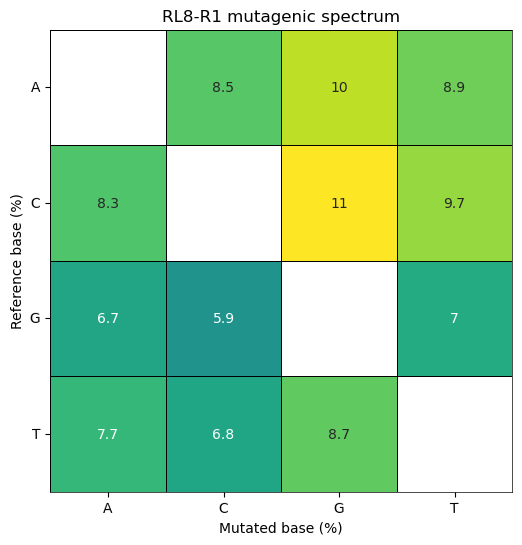

In [758]:
plot_mutation_spectrum(n_mut_spectrum_perc_df, name, fig_folder = FigFolder)

In [712]:
mut_spec_codons, mut_spectrum_codons_perc =  mut_spectrum_codons(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read = False, use_forward_read = True, codon_list = codons, treshold = 10)
mut_spectrum_codons_perc_df = pd.DataFrame.from_dict(mut_spectrum_codons_perc, orient='index')
np.fill_diagonal(mut_spectrum_codons_perc_df.values, np.nan)

In [713]:
mut_spectrum_codons_df = pd.DataFrame.from_dict(mut_spec_codons, orient='index')
mut_spectrum_codons_df.sum().sum()

np.int64(8466)

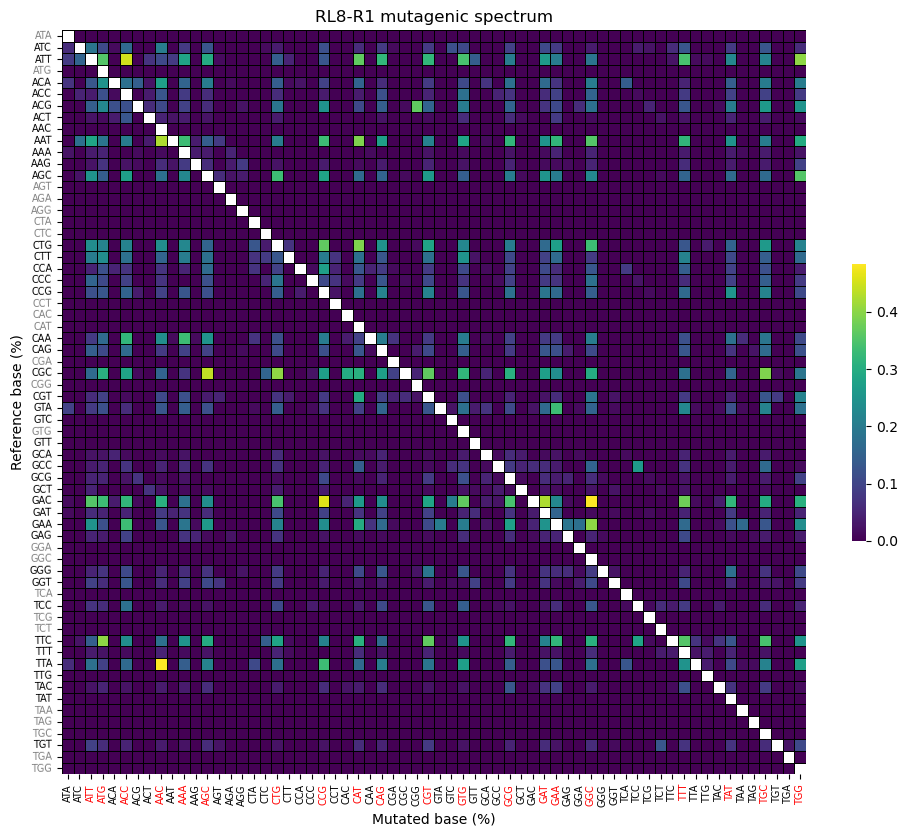

In [716]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(mut_spectrum_codons_perc_df, annot=False, linewidths=.5, ax=ax,  cbar = True, square = True, linecolor = "black", cmap = "viridis", cbar_kws={'shrink': 0.3},  xticklabels=True)
plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base (%)', fontsize = 10)
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(.5)
#ax.set_facecolor('gray')
ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)

for i, tick_label in enumerate(ax.get_xticklabels()):
    if tick_label.get_text() in ecoli_pref.values():
        tick_label.set_color('red')

for i, tick_label in enumerate(ax.get_yticklabels()):
    if tick_label.get_text() not in ref_codons:
        tick_label.set_color('grey')

plt.title(f"{name} mutagenic spectrum", fontsize = 12)
plt.savefig(f"{FigFolder}/{name}_mutagenic_spectrum_codons_perc.pdf")
plt.show()

In [717]:
### calculate expected mutagenic spectrum for RL8 (--> bias because of chosen Codons for AAs) (for R1 reads only)
## Codon wise
variant = "RL8"
name = "RL8-R1"
a_seq, b_seq = read_sequences(variant)
FigFolder = f"{base_dir}/figures/{name}"
max_len_R1 = max([len(seq) for seq in a_seq])
ref_seq = LOV_gene[:max_len_R1]
ref_codons = [ref_seq[i:i+3] for i in range(0, len(ref_seq)//3*3, 3)]
mut_spec_expected = {"A": {"A":0, "C":0, "G":0, "T":0}, ## {reference nt: {mutated nt: count}}
                    "C" : {"A":0, "C":0, "G":0, "T":0},
                    "G" : {"A":0, "C":0, "G":0, "T":0},
                    "T" : {"A":0, "C":0, "G":0, "T":0}}
for ref_codon in ref_codons:
    for mut_codon in ecoli_pref.values():
        ## calculate mutagenic spectrum for all expected changes per Codon
        for idx in range(3):
            if ref_codon[idx] != mut_codon[idx]:
                mut_spec_expected[ref_codon[idx]][mut_codon[idx]] += 1
        

## calculate mutagenic spectrum in percentage
total_n_muts = sum([sum(value.values()) for value in mut_spec_expected.values()])
mut_spec_expected_perc = {ref_base: {mut_base: round(val/total_n_muts*100, 3) for mut_base, val in value.items()} for ref_base, value in mut_spec_expected.items()}
        

total reads 47233


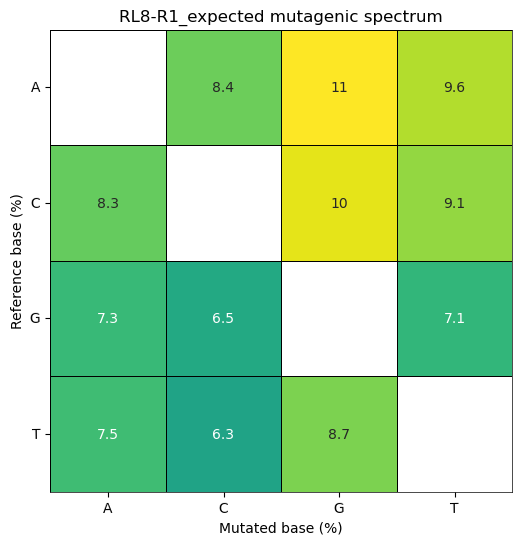

In [457]:
mut_spec_expected_perc_df = pd.DataFrame.from_dict(mut_spec_expected_perc, orient = "index")
np.fill_diagonal(mut_spec_expected_perc_df.values, np.nan)
plot_mutation_spectrum(pd.DataFrame.from_dict(mut_spec_expected_perc_df), samplename = f"{name}_expected", fig_folder = FigFolder)

In [718]:
_, n_mut_spectrum_perc  = mut_spectrum(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=use_backward_read, use_forward_read=use_forward_read, treshold=10)

n_mut_spectrum_perc_df = pd.DataFrame.from_dict(n_mut_spectrum_perc, orient='index')


np.fill_diagonal(n_mut_spectrum_perc_df.values, np.nan) # set diagonal (= filled with zeros, since this is no mutation) to NA (for plotting)

mut_spec_expected_vs_observed = mut_spec_expected_perc_df - n_mut_spectrum_perc_df

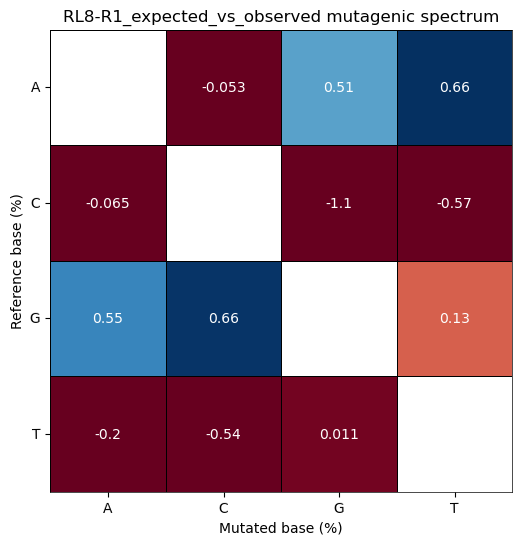

In [719]:
plot_mutation_spectrum(mut_spec_expected_vs_observed, samplename = f"{name}_expected_vs_observed", fig_folder = FigFolder, colormap = "RdBu")

In [720]:
### calculate expected Codon mutagenic spectrum for RL8 (--> bias because of chosen Codons for AAs) (for R1 reads only)

## Codon wise
variant = "RL8"
name = "RL8-R1"
a_seq, b_seq = read_sequences(variant)
FigFolder = f"{base_dir}/figures/{name}"
max_len_R1 = max([len(seq) for seq in a_seq])
ref_seq = LOV_gene[:max_len_R1]
ref_codons = [ref_seq[i:i+3] for i in range(0, len(ref_seq)//3*3, 3)]
codon_list = codons

Codon_mut_spec_expected = {ref_codon: {codon:0 for codon in codon_list} for ref_codon in codon_list} # reference_codon : {mutated_codon: count}

for ref_codon in ref_codons:
    for mut_codon in ecoli_pref.values():
        ## calculate mutagenic spectrum for all expected codons per codon
            if ref_codon != mut_codon:
                Codon_mut_spec_expected[ref_codon][mut_codon] += 1
        

## calculate mutagenic spectrum in percentage
total_n_muts = sum([sum(value.values()) for value in Codon_mut_spec_expected.values()])
Codon_mut_spec_expected_perc = {ref_base: {mut_base: round(val/total_n_muts*100, 3) for mut_base, val in value.items()} for ref_base, value in Codon_mut_spec_expected.items()}



total reads 47233


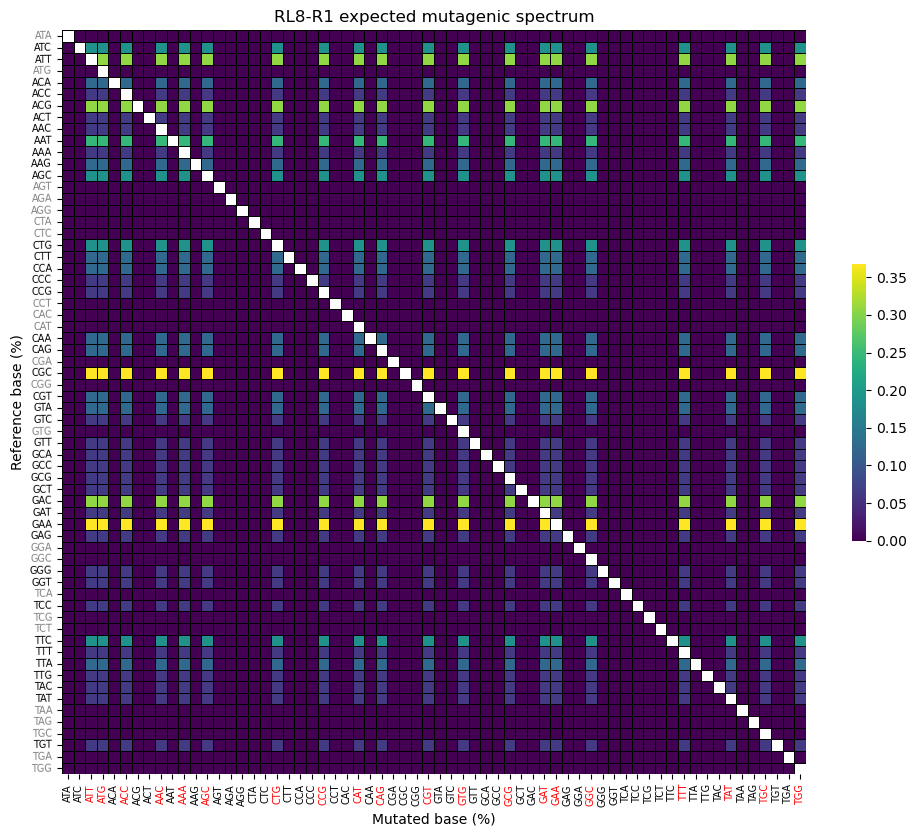

In [722]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(Codon_mut_spec_expected_perc_df, annot=False, linewidths=.5, ax=ax,  cbar = True, square = True, linecolor = "black", cmap = "viridis", cbar_kws={'shrink': 0.3},  xticklabels=True)
plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base (%)', fontsize = 10)
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(.5)
#ax.set_facecolor('gray')
ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)

for i, tick_label in enumerate(ax.get_xticklabels()):
    if tick_label.get_text() in ecoli_pref.values():
        tick_label.set_color('red')

for i, tick_label in enumerate(ax.get_yticklabels()):
    if tick_label.get_text() not in ref_codons:
        tick_label.set_color('grey')

plt.title(f"{name} expected mutagenic spectrum", fontsize = 12)
plt.savefig(f"{FigFolder}/{name}_expected_mutagenic_spectrum_codons_perc.pdf")
plt.show()

In [723]:
mut_spec_codons, mut_spectrum_codons_perc =  mut_spectrum_codons(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read = False, use_forward_read = True, codon_list = codons, treshold = 6)
mut_spectrum_codons_perc_df = pd.DataFrame.from_dict(mut_spectrum_codons_perc, orient='index')
np.fill_diagonal(mut_spectrum_codons_perc_df.values, np.nan)

mut_spectrum_codons_expected_vs_observed = Codon_mut_spec_expected_perc_df - mut_spectrum_codons_perc_df

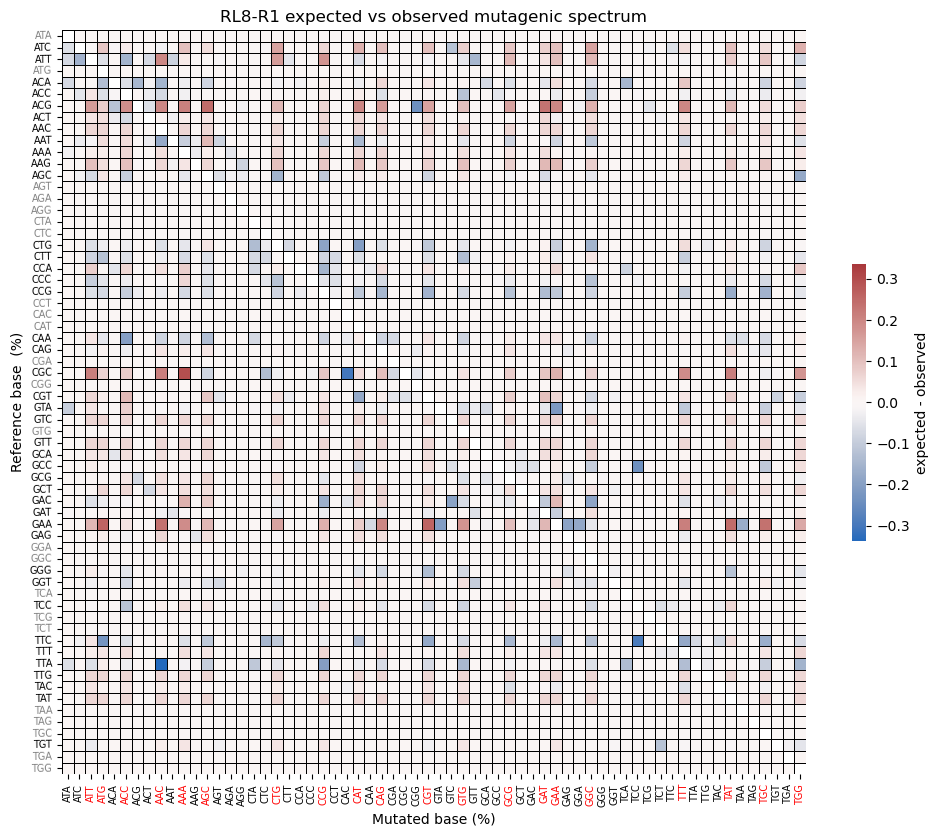

In [725]:
f, ax = plt.subplots(figsize=(12, 12))
cmap_max = np.max(abs(mut_spectrum_codons_expected_vs_observed))
sns.heatmap(mut_spectrum_codons_expected_vs_observed, annot=False, linewidths=.5, ax=ax,  cbar = True, square = True, linecolor = "black", cmap = "vlag",vmin = -cmap_max, vmax = cmap_max ,cbar_kws={'shrink': 0.3, "label" : "expected - observed"},  xticklabels=True)
plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base  (%)', fontsize = 10)
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(.5)
#ax.set_facecolor('gray')
ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)

for i, tick_label in enumerate(ax.get_xticklabels()):
    if tick_label.get_text() in ecoli_pref.values():
        tick_label.set_color('red')


for i, tick_label in enumerate(ax.get_yticklabels()):
    if tick_label.get_text() not in ref_codons:
        tick_label.set_color('grey')

plt.title(f"{name} expected vs observed mutagenic spectrum", fontsize = 12)
plt.savefig(f"{FigFolder}/{name}_expected_vs_observed_mutagenic_spectrum_codons_perc.pdf")
plt.show()

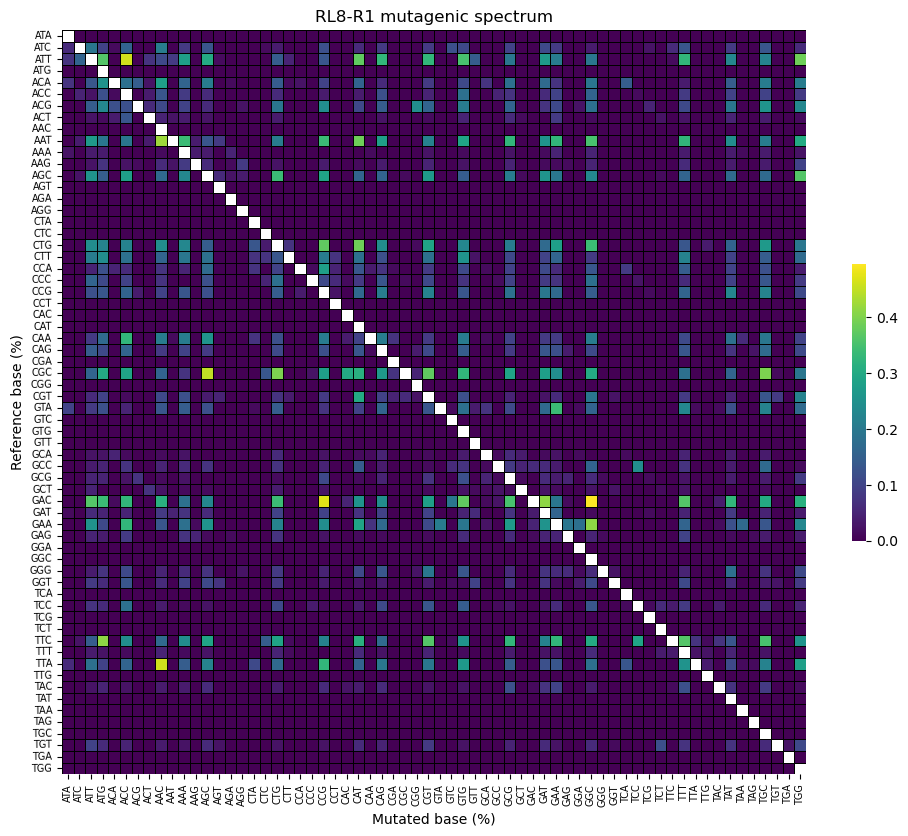

In [726]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(mut_spectrum_codons_perc_df, annot=False, linewidths=.5, ax=ax, vmin = 0, cbar = True, square = True, linecolor = "black", cmap = "viridis", cbar_kws={'shrink': 0.3},  xticklabels=True)
plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base (%)', fontsize = 10)
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(.5)
#ax.set_facecolor('gray')
ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)

# for i, tick_label in enumerate(ax.get_xticklabels()):
#     if tick_label.get_text() in ecoli_pref.values():
#         tick_label.set_color('red')

plt.title(f"{name} mutagenic spectrum", fontsize = 12)
plt.savefig(f"{FigFolder}/{name}_mutagenic_spectrum_codons_perc.pdf")
plt.show()

In [727]:
## calculate number of single/double/triple Nt changes codon-wise
Codon_vars = seq_variants["Codons"]
LOV_codons = [LOV_gene[i:i+3] for i in range(0, Codon_vars.shape[1]*3, 3)]

Nt_changes = {1:0, 2:0, 3:0} # single,double,triple Nt mutations within codons
for pos, mut_Codons in Codon_vars.items(): # iterate columnwise over DF with counts of mutated Codons
    ref_codon = LOV_codons[pos]
    for mut_codon in mut_Codons.index:
        if mut_codon != ref_codon: 
            n_changes = sum([ref_codon[i] != mut_codon[i] for i in range(3)]) # count number of nt changes within the codon
            Nt_changes[n_changes] += mut_Codons[mut_codon] # add the count of the mutated codon to the respective category

relative_Nt_changes_observed = {key: val/sum(Nt_changes.values()) for key,val in Nt_changes.items()}
        

In [728]:
## calculate expected number of single/double/triple Nt changes codon-wise
expected_Nt_changes = {1:0, 2:0, 3:0}

for ref_Codon in LOV_codons: 
    for mut_Codon in ecoli_pref.values(): 
        if mut_Codon != ref_Codon: 
            n_changes = sum([ref_Codon[i] != mut_Codon[i] for i in range(3)])
            expected_Nt_changes[n_changes] += 1

relative_expected_Nt_changes = {key: val/sum(expected_Nt_changes.values()) for key, val in expected_Nt_changes.items()}

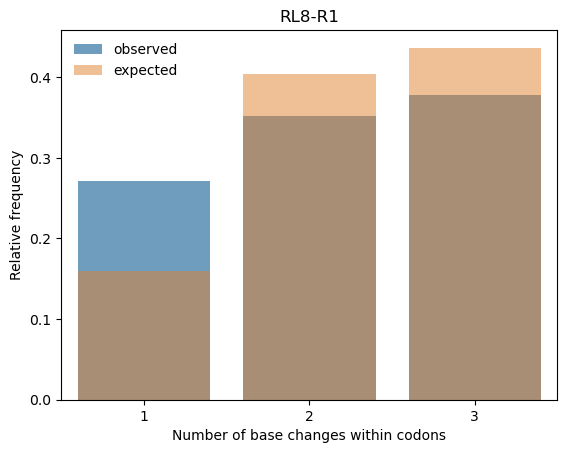

In [729]:
sns.barplot(relative_Nt_changes_observed, alpha = 0.7, label = "observed")
sns.barplot(relative_expected_Nt_changes, alpha = 0.5, label = "expected")
plt.legend(frameon = False)
plt.xlabel("Number of base changes within codons")
plt.ylabel("Relative frequency")
plt.title("RL8-R1")
plt.savefig(f"{FigFolder}/{variant}_base_changes_per_codon_exp_vs_obs.pdf")
plt.show()

In [750]:
Codon_base_bias = {key: obs/relative_expected_Nt_changes[key] for key, obs in relative_Nt_changes_observed.items()}

In [751]:
Codon_base_bias

{1: np.float64(1.7006407340123402),
 2: np.float64(0.8700318515441074),
 3: np.float64(0.8643298213964781)}

In [759]:
### use relative_Nt_changes_observed as background model 
### build background matrix
background_matrix = pd.DataFrame(0.0, index = mut_spectrum_codons_expected_vs_observed.index, columns = mut_spectrum_codons_expected_vs_observed.columns)
for ref_codon in background_matrix.index: 
    for mut_codon in background_matrix.columns: 
        if ref_codon != mut_codon:
            n_changes = sum([ref_codon[i] != mut_codon[i] for i in range(3)])
            background_matrix.loc[ref_codon, mut_codon] = Codon_base_bias[n_changes]

background_exp_matrix = pd.DataFrame(0.0, index = mut_spectrum_codons_expected_vs_observed.index, columns = mut_spectrum_codons_expected_vs_observed.columns)
for ref_codon in background_exp_matrix.index: 
    for mut_codon in background_exp_matrix.columns: 
        if ref_codon != mut_codon:
            n_changes = sum([ref_codon[i] != mut_codon[i] for i in range(3)])
            background_exp_matrix.loc[ref_codon, mut_codon] = relative_expected_Nt_changes[n_changes]

In [760]:
likelihood_model = mut_spectrum_codons_perc_df/background_matrix
likelihood_perc = likelihood_model/likelihood_model.sum().sum()*100
#likelihood_exp = Codon_mut_spec_expected_perc_df/background_exp_matrix
#likelihood_exp_perc = likelihood_exp/likelihood_exp.sum().sum()*100
exp_vs_obs =  Codon_mut_spec_expected_perc_df - likelihood_perc

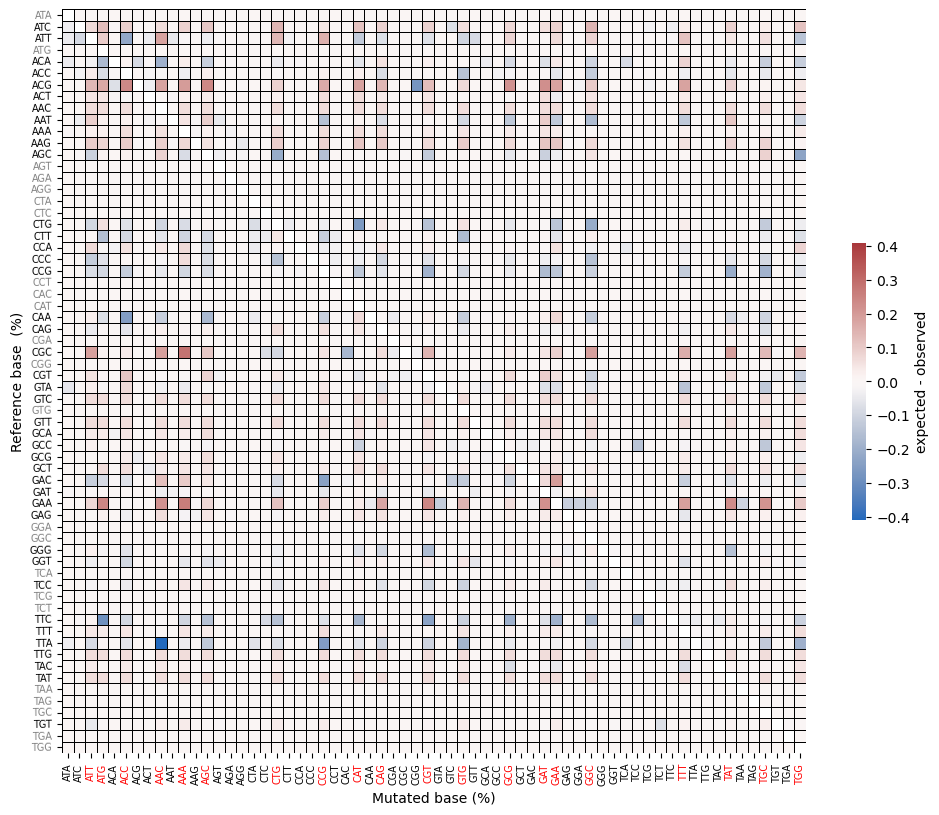

In [761]:
f, ax = plt.subplots(figsize=(12, 12))
cmap_max = np.max(abs(exp_vs_obs))
sns.heatmap(exp_vs_obs, annot=False, linewidths=.5, ax=ax,  cbar = True, square = True, linecolor = "black", cmap = "vlag",vmin = -cmap_max, vmax = cmap_max ,cbar_kws={'shrink': 0.3, "label" : "expected - observed"},  xticklabels=True)
plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base  (%)', fontsize = 10)
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(.5)
#ax.set_facecolor('gray')
ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)

for i, tick_label in enumerate(ax.get_xticklabels()):
    if tick_label.get_text() in ecoli_pref.values():
        tick_label.set_color('red')


for i, tick_label in enumerate(ax.get_yticklabels()):
    if tick_label.get_text() not in ref_codons:
        tick_label.set_color('grey')

# plt.title(f"{name} expected vs observed mutagenic spectrum", fontsize = 12)
# plt.savefig(f"{FigFolder}/{name}_expected_vs_observed_mutagenic_spectrum_codons_perc.pdf")
plt.show()

In [677]:
Codon_mut_spec_expected_perc_df

,ATA,ATC,ATT,ATG,ACA,ACC,ACG,ACT,AAC,AAT,...,TTA,TTG,TAC,TAT,TAA,TAG,TGC,TGT,TGA,TGG
ATA,NaN,0.0,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000
ATC,0.0,NaN,0.184,0.184,0.0,0.184,0.0,0.0,0.184,0.0,...,0.0,0.0,0.0,0.184,0.0,0.0,0.184,0.0,0.0,0.184
ATT,0.0,0.0,NaN,0.307,0.0,0.307,0.0,0.0,0.307,0.0,...,0.0,0.0,0.0,0.307,0.0,0.0,0.307,0.0,0.0,0.307
ATG,0.0,0.0,0.000,NaN,0.0,0.000,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000
ACA,0.0,0.0,0.123,0.123,NaN,0.123,0.0,0.0,0.123,0.0,...,0.0,0.0,0.0,0.123,0.0,0.0,0.123,0.0,0.0,0.123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAG,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.000,0.0,NaN,0.000,0.0,0.0,0.000
TGC,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,NaN,0.0,0.0,0.000
TGT,0.0,0.0,0.061,0.061,0.0,0.061,0.0,0.0,0.061,0.0,...,0.0,0.0,0.0,0.061,0.0,0.0,0.061,NaN,0.0,0.061
TGA,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,NaN,0.000


In [664]:
mut_spectrum_codons_perc_df

,ATA,ATC,ATT,ATG,ACA,ACC,ACG,ACT,AAC,AAT,...,TTA,TTG,TAC,TAT,TAA,TAG,TGC,TGT,TGA,TGG
ATA,NaN,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000
ATC,0.610,NaN,1.335,0.019,0.0,0.305,0.0,0.000,0.019,0.038,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000
ATT,0.191,0.686,NaN,0.248,0.0,0.000,0.0,0.572,0.000,0.362,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000
ATG,0.000,0.000,0.000,NaN,0.0,0.000,0.0,0.000,0.000,0.000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000
ACA,0.458,0.000,0.000,0.000,NaN,0.076,0.4,0.057,0.000,0.000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAG,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,...,0.0,0.0,0.0,0.000,0.0,NaN,0.000,0.0,0.000,0.000
TGC,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,...,0.0,0.0,0.0,0.000,0.0,0.0,NaN,0.0,0.000,0.000
TGT,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,...,0.0,0.0,0.0,0.362,0.0,0.0,0.095,NaN,0.076,0.019
TGA,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,NaN,0.000


In [663]:
likelihood_model

,ATA,ATC,ATT,ATG,ACA,ACC,ACG,ACT,AAC,AAT,...,TTA,TTG,TAC,TAT,TAA,TAG,TGC,TGT,TGA,TGG
ATA,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
ATC,2.249242,NaN,4.922522,0.070058,0.0,1.124621,0.000000,0.000000,0.070058,0.108137,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
ATT,0.704271,2.529476,NaN,0.914446,0.0,0.000000,0.000000,2.109125,0.000000,1.334796,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
ATG,0.000000,0.000000,0.000000,NaN,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
ACA,1.688775,0.000000,0.000000,0.000000,NaN,0.280233,1.474913,0.210175,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAG,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,NaN,0.000000,0.0,0.000000,0.000000
TGC,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,NaN,0.0,0.000000,0.000000
TGT,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,1.334796,0.0,0.0,0.350292,NaN,0.280233,0.070058
TGA,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,NaN,0.000000


## Compare RL8 and DP6

In [417]:
## calculate and plot the number of Nt and Codon mutations per sequence

a_seq, b_seq = read_sequences("DP6")
DP6_n_Nt_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=use_backward_read, use_triplets=False)
DP6_n_Nt_mutations = dict(sorted(DP6_n_Nt_mutations.items())) ## sort dictionary after key

DP6_n_Codon_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=use_backward_read, use_triplets=True)
DP6_n_Codon_mutations = dict(sorted(DP6_n_Codon_mutations.items())) ## sort dictionary after key


a_seq, b_seq = read_sequences("RL8")
RL8_n_Nt_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=use_backward_read, use_triplets=False)
RL8_n_Nt_mutations = dict(sorted(RL8_n_Nt_mutations.items())) ## sort dictionary after key

RL8_n_Codon_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=use_backward_read, use_triplets=True)
RL8_n_Codon_mutations = dict(sorted(RL8_n_Codon_mutations.items())) ## sort dictionary after key


total reads 59259
total reads 47233


In [429]:
RL8_n_Codon_mutation_rates
## calculate average mutation rate 
sum([key*value for value, key in RL8_n_Codon_mutation_rates.items()])/0.86

0.22148880058356332

In [428]:
RL8_n_Codon_mutation_rates

{0: 0.8384952840535205,
 1: 0.13882430357534548,
 2: 0.01930247861373108,
 3: 0.002039921035314762,
 4: 0.0005483658697082694,
 5: 0.00021934634788330776,
 6: 0.0003509541566132924,
 7: 0.00021934634788330776}

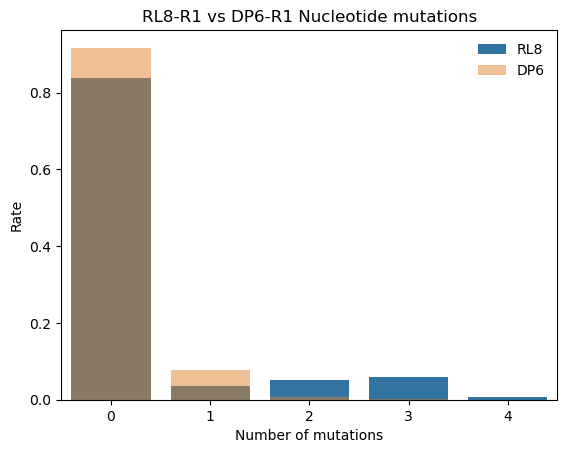

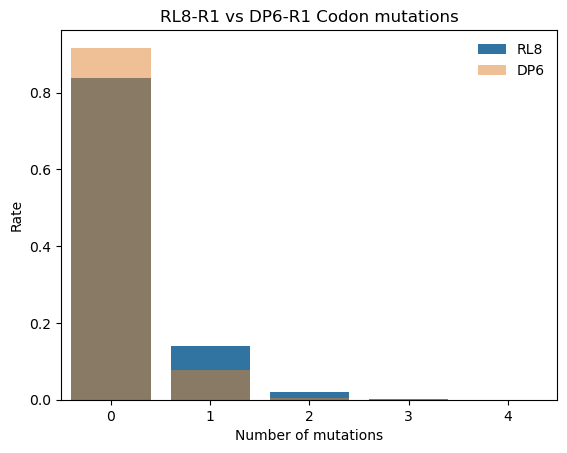

In [418]:
# rates of single, double, triple, ... mutations
total_reads = sum(DP6_n_Nt_mutations.values())
DP6_n_Nt_mutation_rates = {key: value/total_reads for key, value in DP6_n_Nt_mutations.items()}

total_reads = sum(DP6_n_Codon_mutations.values())
DP6_n_Codon_mutation_rates = {key: value/total_reads for key, value in DP6_n_Codon_mutations.items()}


total_reads = sum(RL8_n_Nt_mutations.values())
RL8_n_Nt_mutation_rates = {key: value/total_reads for key, value in RL8_n_Nt_mutations.items()}

total_reads = sum(RL8_n_Codon_mutations.values())
RL8_n_Codon_mutation_rates = {key: value/total_reads for key, value in RL8_n_Codon_mutations.items()}

sns.barplot(RL8_n_Nt_mutation_rates, label = "RL8")
sns.barplot(DP6_n_Nt_mutation_rates, alpha = 0.5, label = "DP6")
plt.legend(frameon = False)
plt.xlim(-0.5,4.5)
plt.xlabel('Number of mutations')
plt.ylabel('Rate')
plt.title(f'{variant}-R1 vs DP6-R1 Nucleotide mutations') 
plt.savefig(f'figures/RL8-R1_vs_DP6-R1_n_Nt_mutation_per_read_rates.pdf')
plt.show()
plt.clf()

sns.barplot(RL8_n_Codon_mutation_rates, label = "RL8")
sns.barplot(DP6_n_Codon_mutation_rates, alpha = 0.5, label = "DP6")
plt.legend(frameon = False)
plt.xlim(-0.5,4.5)
plt.xlabel('Number of mutations')
plt.ylabel('Rate')
plt.title(f'{variant}-R1 vs DP6-R1 Codon mutations') 
plt.savefig(f'figures/RL8-R1_vs_DP6-R1_n_Codon_mutation_per_read_rates.pdf')
plt.show()